### Description
In Case 2, we assume the FIL conserved regime, where investment into the network is fixed. The impact of this from DDO is that b/c gas costs are reduced, we can expect a proportional increase in onboarding. We compare the supply statistics to this case, vs the status-quo where DDO is not implemented.

We expect the following to occur:
1. Gas cost is likely to go to 0.  This is b/c we would need to see a proportional increase of onboarding much larger such that block-space is filled up, than the percentage of costs of onboarding due to gas costs. More explicitly, gas costs are about 3% of onboarding costs.  However, we would need to see a 3x increase in onboarding to fill up the block-space (comes from the expected decrease in PSD costs). This asymetry causes block space to not be filled, and thus the base-fee is expected to go to zero, and consequently gas costs will go to 0.
2. The reduced gas costs will result in increased onboarding, which changes locking and circ-supply.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import pystarboard.data_spacescope as data_spacescope
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.date_utils as date_utils
import mechafil.data as d
import mechafil.data_spacescope as dss
import mechafil_jax.constants as C
import scenario_generator.utils as u
import cel_utils.disk_utils as du

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v2')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

### Step 1 - Establish baseline for Circulating Supply

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
lock_target = 0.3
forecast_length = 365*3
sector_duration = 540

current_date = date.today() - timedelta(days=3)
mo = current_date.month - 2  # get 2 mo historical data to get better estimate of gas burn
if mo == 0: mo = 1
start_date = date(current_date.year, mo, 1)
end_date = current_date + timedelta(days=forecast_length)

print(start_date, current_date, end_date)

2023-08-01 2023-10-20 2026-10-19


In [5]:
@du.cache_data(offline_dir)
def get_offline_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

In [6]:
smooth_historical_rbp = np.median(hist_rbp[-90:])
smooth_historical_rr = np.median(hist_rr[-90:])
smooth_historical_fpr = np.median(hist_fpr[-90:])

In [7]:
rbp = jnp.ones(forecast_length) * smooth_historical_rbp
rr = jnp.ones(forecast_length) * smooth_historical_rr
fpr = jnp.ones(forecast_length) * smooth_historical_fpr

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

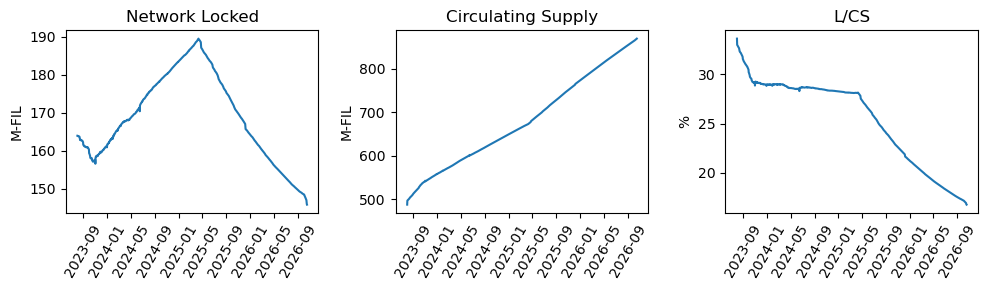

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

t = date_utils.get_t(start_date, end_date=end_date)

axx = ax[0]
axx.plot(t, simulation_results['network_locked']/1e6)
axx.set_title('Network Locked')
axx.set_ylabel('M-FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1]
axx.plot(t, simulation_results['circ_supply']/1e6)
axx.set_title('Circulating Supply')
axx.set_ylabel('M-FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(t, simulation_results['network_locked']/simulation_results['circ_supply'] * 100)
axx.set_title('L/CS')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()

### Step 2 - estimate the percentage of total cost that is attributable to gas

In [9]:
# This comes from Angelo's Cost Estimator, and was used for discussing SP costs and ranking FIL strategies here:
#  https://filspcostexplorer.streamlit.app/
# The default values were computed from Angelo's spreadsheets

def get_negligible_costs(bandwidth_10gbps_tib_per_yr):
    # Definitions (we can make these configurable later, potentially)
    sealing_costs_tib_per_yr = 1.3

    gas_cost_tib_per_yr = (2250.+108.)/1024.
    gas_cost_without_psd_tib_per_yr = 108./1024.
    bandwidth_1gbps_tib_per_yr=bandwidth_10gbps_tib_per_yr/10.0

    return sealing_costs_tib_per_yr, gas_cost_tib_per_yr, gas_cost_without_psd_tib_per_yr, bandwidth_1gbps_tib_per_yr

def compute_costs(
    expected_rewards_per_tib, 
    filp_multiplier=10, rd_multiplier=1, cc_multiplier=1,
    exchange_rate=4.0, borrowing_cost_pct=50,
    filp_bd_cost_tib_per_yr=8.0, rd_bd_cost_tib_per_yr=3.2,
    deal_income_tib_per_yr=16.0,
    data_prep_cost_tib_per_yr=1.0, penalty_tib_per_yr=0.0,
    power_cost_tib_per_yr=6, 
    bandwidth_10gbps_tib_per_yr=6, 
    staff_cost_tib_per_yr=10
):
    erpt = expected_rewards_per_tib
    
    sealing_costs_tib_per_yr, gas_cost_tib_per_yr, gas_cost_without_psd_tib_per_yr, bandwidth_1gbps_tib_per_yr = get_negligible_costs(bandwidth_10gbps_tib_per_yr)
    
    # create a dataframe for each of the miner profiles
    filp_miner = {
        'SP Type': 'FIL+',
        'block_rewards': erpt*exchange_rate*filp_multiplier,
        'deal_income': deal_income_tib_per_yr,
        'pledge_cost': erpt*exchange_rate*filp_multiplier*borrowing_cost_pct,
        'gas_cost': gas_cost_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_10gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': data_prep_cost_tib_per_yr,
        'bd_cost': filp_bd_cost_tib_per_yr,
        'extra_copy_cost': (staff_cost_tib_per_yr+power_cost_tib_per_yr)*0.5,
        'cheating_cost': 0
    }
    cc_miner = {
        'SP Type':'CC',
        'block_rewards': erpt*exchange_rate*cc_multiplier,
        'deal_income': 0,
        'pledge_cost': erpt*exchange_rate*borrowing_cost_pct*cc_multiplier,
        'gas_cost': gas_cost_without_psd_tib_per_yr,
        'power_cost': power_cost_tib_per_yr,
        'bandwidth_cost': bandwidth_1gbps_tib_per_yr,
        'staff_cost': staff_cost_tib_per_yr,
        'sealing_cost': sealing_costs_tib_per_yr,
        'data_prep_cost': 0,
        'bd_cost': 0,
        'extra_copy_cost': 0,
        'cheating_cost': 0
    }
    df = pd.DataFrame([filp_miner, cc_miner])
    # add final accounting to the DF
    revenue = df['block_rewards'] + df['deal_income']
    cost = (
        df['pledge_cost'] 
        + df['gas_cost'] 
        + df['power_cost'] 
        + df['bandwidth_cost'] 
        + df['staff_cost'] 
        + df['sealing_cost'] 
        + df['data_prep_cost'] 
        + df['bd_cost'] 
        + df['extra_copy_cost'] 
        + df['cheating_cost']
    )
    df['profit'] = revenue-cost
    gas_cost_frac = df['gas_cost'] / cost

    return df, gas_cost_frac

In [10]:
ix_current_date = (current_date-start_date).days
expected_rewards_per_sector_today = float(simulation_results['1y_return_per_sector'][ix_current_date])

# extract the block-rewards per tib for each scenario
sectors_per_tib = (1024**4) / C.SECTOR_SIZE
brpt = expected_rewards_per_sector_today * sectors_per_tib
print(brpt)

1.6659833192825317


In [11]:
compute_costs(brpt, exchange_rate=4)[0]

,SP Type,block_rewards,deal_income,pledge_cost,gas_cost,power_cost,bandwidth_cost,staff_cost,sealing_cost,data_prep_cost,bd_cost,extra_copy_cost,cheating_cost,profit
0,FIL+,66.639333,16.0,3331.966639,2.302734,6,6.0,10,1.3,1.0,8.0,8.0,0,-3291.930040
1,CC,6.663933,0.0,333.196664,0.105469,6,0.6,10,1.3,0.0,0.0,0.0,0,-344.538199


Text(0.5, 1.0, 'Gas Cost Pct. of Total Cost \n Avg=0.025 %')

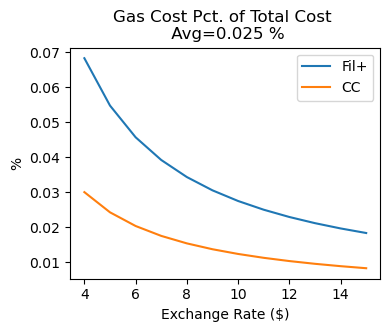

In [34]:
# plot the percentage of costs that are gas costs, as a function of exchange rate
exchange_rate = np.arange(4, 15+1)
filp_gas_cost_pct_vec = np.zeros_like(exchange_rate).astype(float)
cc_gas_cost_pct_vec = np.zeros_like(exchange_rate).astype(float)
for ii, e in enumerate(exchange_rate):
    _, gas_cost_pct = compute_costs(brpt, exchange_rate=e)
    filp_gas_cost_pct = gas_cost_pct.iloc[0]
    cc_gas_cost_pct = gas_cost_pct.iloc[1]
    
    filp_gas_cost_pct_vec[ii] = filp_gas_cost_pct
    cc_gas_cost_pct_vec[ii] = cc_gas_cost_pct

# Average across all vectors
avg_all_gas_cost = np.mean(np.concatenate([filp_gas_cost_pct_vec, cc_gas_cost_pct_vec]))

plt.figure(figsize=(4,3))
plt.plot(exchange_rate, filp_gas_cost_pct_vec*100, label='Fil+')
plt.plot(exchange_rate, cc_gas_cost_pct_vec*100, label='CC')
plt.legend()
plt.xlabel('Exchange Rate ($)')
plt.ylabel('%')
plt.title('Gas Cost Pct. of Total Cost \n Avg=%0.03f %%' % (avg_all_gas_cost*100,))

### Step 3 - Update gas_burn to simulate base_fee --> 0, incorporate increase in RBP due to reduced gas cost

In [13]:
# In this case, gas_burn is from sources other than base_fee burn
# get the historical data and use it to make a forecast on gas_burn, by extending median values of historical data
# NOTE: the forecasting complexity could be increased.

sso = data_spacescope.SpacescopeDataConnection(token)
lookback_days = 180
sd = current_date - timedelta(days=lookback_days)
network_fee_breakdown_df = sso.spacescope_query(sd, current_date, 
                     'https://api.spacescope.io/v2/gas/daily_network_fee_breakdown?end_date=%s&start_date=%s')

In [14]:
network_fee_breakdown_df

,stat_date,base_fee_burn,overestimation_burn,precommit_batch_fee_burn,provecommit_batch_fee_burn,penalty_fee_burn,miner_tip
0,2023-04-23T00:00:00Z,12184.438819,1283.940441,205.005719,295.861460,2771.501971,4846.239528
1,2023-04-24T00:00:00Z,12722.786847,1559.948006,136.470541,154.592389,2102.561875,2740.913931
2,2023-04-25T00:00:00Z,14984.098955,1778.190497,167.833540,262.547004,3453.968950,3493.941916
3,2023-04-26T00:00:00Z,1968.123727,214.969081,29.875783,54.328570,3963.776371,3074.283552
4,2023-04-27T00:00:00Z,296.561701,24.737545,25.701719,78.707406,1413.258320,1107.607203
...,...,...,...,...,...,...,...
176,2023-10-16T00:00:00Z,0.004533,0.000315,0.000000,18.487490,11181.133601,10.246533
177,2023-10-17T00:00:00Z,0.004028,0.000260,0.000000,58.420467,33884.684184,10.964621
178,2023-10-18T00:00:00Z,0.006979,0.000549,0.000000,41.978927,1257.757410,11.914248
179,2023-10-19T00:00:00Z,0.039597,0.003064,0.000000,50.532472,967.279886,15.525253


In [15]:
# get a baseline burn forecast
other_burns = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip']
all_burn_cols = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip', 'base_fee_burn']
burn_without_basefee = network_fee_breakdown_df[other_burns].sum(axis=1).values
full_burn = network_fee_breakdown_df[all_burn_cols].sum(axis=1).values
median_burn_pct_notbasefee = np.median(burn_without_basefee/full_burn)
print(median_burn_pct_notbasefee)

0.36657503936049785


In [16]:
offline_data_updated_gas_burn = copy.deepcopy(offline_data)
gas_burn_forecast = np.ones(forecast_length)*offline_data['daily_burnt_fil']*median_burn_pct_notbasefee
burnt_fil_vec = np.concatenate([offline_data_updated_gas_burn['burnt_fil_vec'][1:], gas_burn_forecast])
offline_data_updated_gas_burn['burnt_fil_vec'] = burnt_fil_vec

In [38]:
gas_cost_frac = avg_all_gas_cost

rbp_scaling = [0.95, 0.98, 1, 1.02, 1.05]

rbp_scale_to_results = {}

for sc in rbp_scaling:
    rbp = jnp.ones(forecast_length) * (smooth_historical_rbp/(1-gas_cost_frac)) * sc
    rr = jnp.ones(forecast_length) * smooth_historical_rr
    fpr = jnp.ones(forecast_length) * smooth_historical_fpr
    
    simulation_results_updated_gasburn = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data_updated_gas_burn
    )

    rbp_scale_to_results[sc] = simulation_results_updated_gasburn

In [39]:
scale2str = {sc:'%0.02fx' % (sc,) for sc in rbp_scaling}
scale2str[1] = 'FIL Conserved'

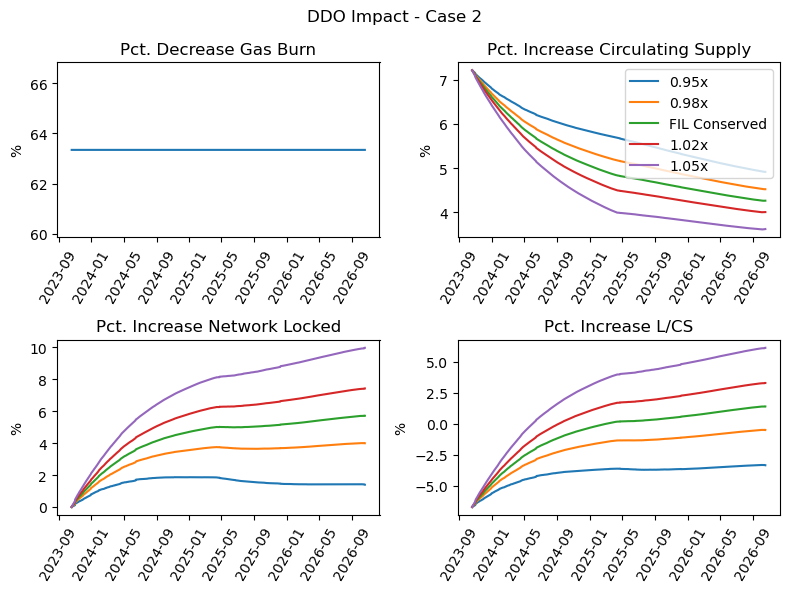

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

t = date_utils.get_t(current_date, end_date=end_date)
offset = (current_date-start_date).days

axx = ax[0,0]
status_quo_burn_fil_vec = np.ones(forecast_length)*offline_data['daily_burnt_fil']
x = gas_burn_forecast
y = status_quo_burn_fil_vec
axx.plot(t, (y-x)/y*100)
axx.set_ylabel('%')
axx.set_title('Pct. Decrease Gas Burn')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[0,1]
x = simulation_results['circ_supply'][offset:]
for sc in rbp_scaling:
    simulation_results_updated_gasburn = rbp_scale_to_results[sc]
    y = simulation_results_updated_gasburn['circ_supply'][offset:]
    axx.plot(t, (y-x)/x*100, label=scale2str[sc])
axx.set_title(r'Pct. Increase Circulating Supply')
axx.set_ylabel('%')
axx.legend()
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1,0]
x = simulation_results['network_locked'][offset:]
for sc in rbp_scaling:
    simulation_results_updated_gasburn = rbp_scale_to_results[sc]
    y = simulation_results_updated_gasburn['network_locked'][offset:]
    axx.plot(t, (y-x)/x*100)
axx.set_title(r'Pct. Increase Network Locked')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1,1]
x = simulation_results['network_locked'][offset:]/simulation_results['circ_supply'][offset:]
for sc in rbp_scaling:
    simulation_results_updated_gasburn = rbp_scale_to_results[sc]
    y = simulation_results_updated_gasburn['network_locked'][offset:]/simulation_results_updated_gasburn['circ_supply'][offset:]
    axx.plot(t, (y-x)/x*100)
axx.set_title(r'Pct. Increase L/CS')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.suptitle('DDO Impact - Case 2')
plt.tight_layout()